In [169]:
import sys
import skimage
from skimage import data, feature, filters, color, img_as_float
from scipy import misc
from skimage.filters import threshold_yen
from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt
from matplotlib import cm
from skimage.morphology import skeletonize
from skimage.feature import canny
import numpy as np
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage import io
from skimage import img_as_uint
import glob
from PIL import Image
import imageio
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
from skimage.color import label2rgb
import tifffile
import pims
import pandas as pd

from matplotlib.widgets  import RectangleSelector
import math
from scipy.interpolate import interp1d
from scipy import interpolate
import operator
import trackpy as tp

##### FUNCTION to smooth a list of x y coordinates along a line that have pixelated edges #####
##### takes the average between 2 consecutive values and appends to a list                #####
def smooth(x,y):
    newx = []
    newy = []
    for i in range(0,len(x)-1):
        avgx = np.mean([x[i],x[i+1]])
        avgy = np.mean([y[i],y[i+1]])
        newx.append(avgx)
        newy.append(avgy)
    return(newx,newy)

##### DON'T FORGET TO UPDATE PATH #####
path = "/Users/poojasuresh/Documents/iPQB/DumontLab/image_processing/test_skeletonize/houghtransforms/20171215_8"

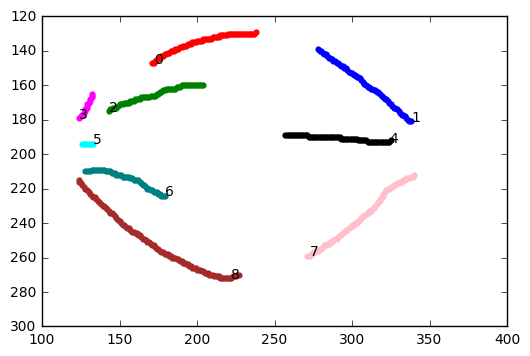

before object merging: there are 9 objects
# of object-merges: 0
after object merging: there are 9 objects
Objects to delete (END W/ COMMA): 3,5,
5
3
after deleting: there are 7 objects
FRAME 0


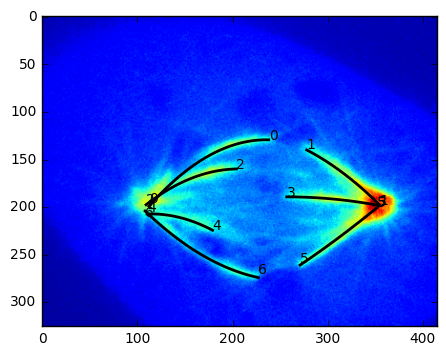

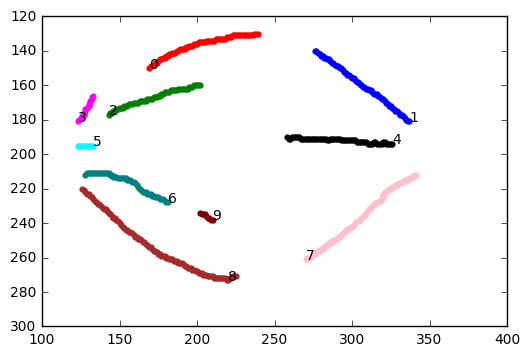

before object merging: there are 10 objects


KeyboardInterrupt: 

In [195]:
index_list = []
for filename in glob.glob('%s/testavg_*.tif'%path):
    index = filename.lstrip('%s/test'%path).rstrip('.tif')
    index_final = index.lstrip('vg_')
    index_list.append(index_final)
    
    ##### READ IMAGE #####
    img = misc.imread(filename)

    #####DIFFERENCE OF GAUSSIAN FILTER#####
    ##### I have been using sigma = 3/5 (optimized for myself) #####
    s1 = filters.gaussian(img,3)
    s2 = filters.gaussian(img,5)
    dog = s1 - s2

    ##### THRESHOLD OTSU #####
    ##### Otsu has been most consistent/reproducible for me #####
    global_thresh = threshold_otsu(dog)
    binary_global = dog > global_thresh

    ##### SKELETONIZING #####
    skeleton = skeletonize(binary_global)

    ##### write and save images as .TIF #####
    imageio.imwrite('%s/img_%s.tif'%(path,index_final),img)
    imageio.imwrite('%s/DoG_%s.tif'%(path,index_final),dog)
    imageio.imwrite('%s/threshold_%s.tif'%(path,index_final),binary_global*1) #### boolean to binary by multiplying by 1
    imageio.imwrite('%s/skeleton_%s.tif'%(path,index_final),skeleton*1) #### boolean to binary by multiplying by 1/

##### READ .TIF images and call them by a name #####
##### Example: If you want to read the nth image in skel (which is a series of tifs) ==> skel[n] #####
skel = pims.ImageSequence("%s/skeleton_*.tif"%path)
img = pims.ImageSequence("%s/img_*.tif"%path)
DoG = pims.ImageSequence("%s/DoG_*.tif"%path)
thresh = pims.ImageSequence("%s/threshold_*.tif"%path)

##### DISPLAY IMAGE PROCESSING STEP OUTPUTS (first image in series processed)#####
#plt.imshow(img[0])
#plt.show()
#plt.imshow(DoG[0])
#plt.show()
#plt.imshow(thresh[0])
#plt.show()
#plt.imshow(skel[0])
#plt.show()

##### READ .CSV FILE SAVED IN PATH FOLDER: OUTPUT OF TRACKING BOTH SPINDLE POLES USING FIJI'S MTRACKJ PLUGIN#####
##### ALSO, RENAME columns 3 and 4 to have a universally common name, since sometimes fiji calls them by a few different variations #####
pole = pd.read_csv('%s/polecoords.csv'%path)
pole.rename(columns={pole.columns[3]:'x (px)'}, inplace=True)
pole.rename(columns={pole.columns[4]:'y (px)'}, inplace=True)

##### CALL X AND Y COORDINATES OF EACH POLE AS A VARIABLE #####
pole1x = pole[(pole['TID'] == 1)]['x (px)']
pole1x = pole1x.reset_index(drop=True) ##### resets index to start from 0
pole1y = pole[(pole['TID'] == 1)]['y (px)']
pole1y = pole1y.reset_index(drop=True)
pole2x = pole[(pole['TID'] == 2)]['x (px)']
pole2x = pole2x.reset_index(drop=True)
pole2y = pole[(pole['TID'] == 2)]['y (px)']
pole2y = pole2y.reset_index(drop=True)

img_shape = img[0].shape ###tuple (x_dimension, y_dimension)
for i in range(len(pole1x)):
    
    ##### CREATE MATRIX OF ONES (SAME DIMENSIONS AS THE IMAGES), A MATRIX FOR EACH FRAME IN THE SERIES #####
    exec("a_%s = np.ones((img_shape[0], img_shape[1]),dtype=int)"%i) 
    ##### FOR EACH FRAME, CALCULATE THE X Y COORDINATES THAT DEFINE THE EDGES OF THE SQUARE AROUND EACH POLE #####
    ##### THE EDGES ARE SETUP 15 PIXELS +/- THE POLE COORDINATE #####
    x1min = int(pole1x[i]-15)
    x1max = int(pole1x[i]+15)
    y1min = int(pole1y[i]-15)
    y1max = int(pole1y[i]+15)
    x2min = int(pole2x[i]-15)
    x2max = int(pole2x[i]+15)
    y2min = int(pole2y[i]-15)
    y2max = int(pole2y[i]+15)
    ##### REPLACE ZEROES IN THE POSITIONS WITHIN THE SQUARE DEFINED ABOVE #####
    exec("a_%s[y1min-1:y1max-1,x1min-1:x1max-1] = 0"%i)
    exec("a_%s[y2min-1:y2max-1,x2min-1:x2max-1] = 0"%i)


############################################################################################################
############################################################################################################
############################################################################################################

    
##### CREATE 2 NEW DATAFRAMES WITH THE FOLLOWING COLUMN NAMES #####
df_prop = pd.DataFrame(columns=['frame','object','length (um)'])
df_coords = pd.DataFrame(columns=['frame','object','x (px)','y (px)','particle'])

fig, ax = plt.subplots()

framerange_list = range(0,10)
for i in framerange_list:
    framenum = i
    
    ##### MASK SKELETON IMAGE BY MULTIPLYING THE MASK MATRIX TO THE SKELETON MATRIX #####
    ##### "NEW" IS THE SKELETONIZED IMAGE WITH THE POLE MASKED OUT #####
    exec("new = skel[%s] * a_%s"%(i,i))
    label_image = label(new)
    regions = regionprops(label_image)
    
    ##### FILTER REGIONS LARGER THAN 8 PIXELS^2 AREA #####
    ##### APPEND FILTERED REGION AND COORDS TO NEW LISTS #####
    newregions_coords = []
    newregions = []
    for i in range(len(regions)):
        if regions[i].area >=8:
            newregions_coords.append(regions[i].coords)
            newregions.append(regions[i])
    
    ##### PLOT EACH REGION #####
    colors = ['red','blue','green','magenta','black','cyan','teal','pink','brown','maroon','lightskyblue','turquoise','grey','coral','seagreen','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(len(newregions)):
        region = newregions[i].coords
        y, x = region.T
        plt.scatter(x,y, c=colors[i], lw = 0, label="%s"%i)
        plt.text(x[-1], y[-1], '{i}'.format(i=i)) ##labelling each object on image
    #plt.xlim(0,500)
    #plt.ylim(0,500)
    plt.gca().invert_yaxis()
    plt.show()
    
    print "before object merging: there are %s objects" %len(newregions_coords)
    objmerg_num = input("# of object-merges: ") ##### HOW MANY OBJECT SETS NEED TO BE MERGED TO THE SAME K-FIBER? 
    
    ##### FOR EACH SET TO BE MERGED, LIST THE REGION LABELS AS a,b,c... IN ASCENDING ORDER #####
    ##### MERGE THOSE REGIONS AND THEN INSERT IN THE SAME POSITION AS THE LOWEST LABEL #####
    for i in range(1,objmerg_num+1):
        set = input('Objects to be merged (set %s) (END W/ COMMA): '%i)
        if len(set) == 2:
            newregions_coords.insert(set[0],np.concatenate((newregions_coords[set[0]], newregions_coords[set[1]]), axis=0))
            #newregions_coords.append(np.append(newregions[set[0]].coords, newregions[set[1]].coords, axis=0))
            del newregions_coords[set[1]+1]
            del newregions_coords[set[0]+1]
        if len(set) == 3:
            newregions_coords.insert(set[0],np.concatenate((newregions_coords[set[0]], newregions_coords[set[1]], newregions_coords[set[2]]), axis=0))
            del newregions_coords[set[2]+1]
            del newregions_coords[set[1]+1]
            del newregions_coords[set[0]+1]
        if len(set) == 4:
            newregions_coords.insert(set[0],np.concatenate((newregions_coords[set[0]], newregions_coords[set[1]], newregions_coords[set[2]], newregions_coords[set[3]]), axis=0))
            del newregions_coords[set[3]+1]
            del newregions_coords[set[2]+1]
            del newregions_coords[set[1]+1]
            del newregions_coords[set[0]+1]

        ##### PLOT REGIONS AFTER EACH ITERATION OF MERGES TO SEE THE NEW UPDATED REGION LABELS #####
        ##### THIS HELPS INFORM THE NEXT ITERATION OF MERGES OR DELETIONS AFTER #####
        for j in range(len(newregions_coords)):
            y, x = newregions_coords[j].T
            plt.scatter(x,y, color = colors[j], lw = 0)
            plt.plot(x,y,'-')
            plt.text(x[-1], y[-1], '{j}'.format(j=j))
        plt.gca().invert_yaxis()
        plt.show()
    
    print "after object merging: there are %s objects" %len(newregions_coords) ##### AFTER ALL MERGES AND DELETIONS, THE TOTAL NUMBER OF OBJECTS REMAINING

    ##### LIST THE REGIONS TO BE DELETED AS a,b,c... #####
    ##### IF THERE IS ONLY ONE REGION, LIST AS a, (IT WILL ERROR OUT IF YOU FORGET THE COMMA AT THE END)#####
    delnum = input("Objects to delete (END W/ COMMA): ")
    for i in range(len(delnum)):
        print delnum[-1-i]
        del newregions_coords[delnum[-1-i]]
    
    print "after deleting: there are %s objects" %len(newregions_coords)
    
    ##### ADD POLE COORDINATE BACK IN, SPLINE AND POLYNOMIAL FIT #####
    for j in range(len(newregions_coords)):
        obj = j
        region = newregions_coords[j] ##### FINAL POOL OF REGIONS AFTER MERGES AND DELETIONS
        y,x = region.T

        ##### IF MEAN XY POSITION OF A REGION IS CLOSER TO POLE1 THAN POLE2, THEN APPEND XY POLE1 COORD TO THE END OF THE REGION-COORD ARRAY #####
        ##### IF NOT, THEN APPEND XY POLE2 COORD TO THE END OF THE REGION-COORD ARRAY #####        
        if float(np.hypot(np.mean(x)-pole1x[j],np.mean(y)-pole1y[j])) <= float(np.hypot(np.mean(x)-pole2x[j],np.mean(y)-pole2y[j])):
            region = np.insert(region,-1,[pole1y[j],pole1x[j]],axis=0) ##### -1 IS THE LAST POSITION IN THE ARRAY
            y_region, x_region = region.T
        else:
            region = np.insert(region,-1,[pole2y[j], pole2x[j]],axis=0)
            y_region, x_region = region.T

        
        ##### SORT THE ORDER OF XY COORDINATES OF EACH REGION ACCORDING TO ASCENDING X ORDER #####
        L = sorted(zip(x_region,y_region), key=operator.itemgetter(0))
        x_sorted, y_sorted = zip(*L)
        x_complete=list(x_sorted)
        y_complete=list(y_sorted)

        ##### LINEAR SPLINE FIT WITHIN EACH REGION #####
        f = interp1d(x_complete, y_complete, kind='linear')
        xdens = np.linspace(min(x_complete), max(x_complete), 200)
        ydens=f(xdens)
        plt.text(xdens[-1], ydens[-1], '{j}'.format(j=j))
        plt.text(xdens[0], ydens[0], '{j}'.format(j=j))
        
        ##### POLYNOMIAL FIT OF POLY 2 #####
        fit=np.polyfit(xdens,ydens,2)
        val = np.polyval(fit, xdens)
        plt.plot(xdens,val, color='k', lw=2)
        plt.imshow(img[framenum])
        plt.gca().invert_yaxis()

        ##### MEASURE LENGTH OF K-FIBER FOR EACH FRAME #####
        distanceWalked = 0
        for i in range(len(x)-1):
            distanceWalked = distanceWalked  + ((xdens[i+1]-xdens[i])**2 + (val[i+1]-val[i]) **2)**.5
        
        ##### APPEND INFO TO DATAFRAMES #####
        df_prop = df_prop.append({'frame': int(framenum), 'object': int(obj), 'length (um)': distanceWalked*0.0657}, ignore_index=True)

        for coord in range(len(val)):
            df_coords = df_coords.append({'frame': int(framenum), 'object': int(obj), 'x (px)': xdens[coord], 'y (px)': val[coord], 'particle': int(coord)}, ignore_index=True)

    print "FRAME %s" %framenum
    plt.gca().invert_yaxis()
    plt.show()

#print df_prop
#print df_coords

############################################################################################################
############################################################################################################
############################################################################################################

#############CORRECTING MISLABELED OBJECTS#############
##### rename the dataframes from above so you can make modifications to them while still keeping the original #####
coords = df_coords ###original df_coords (leave unchanged), new modifications to be made in coords
props = df_prop

objectrange_list = sorted(list(coords.object.unique()))

##### OBJECT REORDERING ACCORDING TO ANGLE OF OBJECT'S MEAN POSITION FROM THE CENTER OF WHOLE SPINDLE: low to high angles ==> quadrant order 4,1,2,3 #####
##### sorting_dict ==> key: angle, value: orig object number #####
##### mapping_dict ==> key: orig object in ascending order of corresponding angle, value: new object number based on ascending order of angles #####
##### fr_map_dict ==> key: frame number, value: mapping_dict ##### 
fr_map_dict={} 
for fr in framerange_list:
    sorting_dict = {} ###logs the angle of each object with respect to the center of the whole image.
    xmean_spindle = np.mean(np.mean(coords.loc[(coords["frame"] == float(fr)), "x (px)"]))
    ymean_spindle = np.mean(np.mean(coords.loc[(coords["frame"] == float(fr)), "y (px)"]))
    for obj in objectrange_list:
        xmean_obj = np.mean(coords.loc[(coords["frame"] == float(fr)) & (coords["object"] == float(obj)), "x (px)"])
        ymean_obj = np.mean(coords.loc[(coords["frame"] == float(fr)) & (coords["object"] == float(obj)), "y (px)"])
        theta_deg = np.degrees(np.arctan((ymean_obj - ymean_spindle)/(xmean_obj - xmean_spindle)))
        if xmean_obj-xmean_spindle < 0:
            theta_deg += 180
        sorting_dict[theta_deg] = obj
    mapping_dict = {}
    for my_idx,my_val in enumerate(sorted(sorting_dict.keys())):
        #print my_val, sorting_dict[my_val], my_idx
        mapping_dict[sorting_dict[my_val]] = my_idx ## they keys in sorting_dict are ordered from low to high. The values corresponding to the ordered angles in sorting_dict are the keys in mapping_dict, while the enumerated indices are the values in mapping_dict
    #print mapping_dict
    fr_map_dict[fr]=mapping_dict ## logs frame number as key to each mapping_dict as value (so it can be mapped to the right framenums in dataframe )

##### MAPPING to DATAFRAMES, NEW COLUMN CALLED "ordered_object" HAS THE CORRECT OBJECT LABELS #####
coords['ordered_object']=coords[['frame','object']].apply(lambda x: fr_map_dict[x[0]][x[1]], axis=1)
props['ordered_object']=props[['frame','object']].apply(lambda x: fr_map_dict[x[0]][x[1]], axis=1)

##### PLOT ALL OBJECTS IN ALL FRAMES WITH THE CORRECTED/ORDERED OBJECT LABELS (SHOWN BY COLOR) #####
for fr in framerange_list:
    for obj in objectrange_list:
        x = coords.loc[(coords["frame"] == float(fr)) & (coords["ordered_object"] == float(obj)), "x (px)"]
        y = coords.loc[(coords["frame"] == float(fr)) & (coords["ordered_object"] == float(obj)), "y (px)"]
        plt.plot(x,y,label="%s"%obj)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.show()

##### NEW COLUMN NEEDS TO BE ADDED IN COORDS DF: PARTICLE (SETTING UP FOR TRACKPY-BASED DEFORMATION MAP GENERATION) #####
coords['frame'] = coords.frame.astype(int) ##### convert to integer: example 1.0 to just 1
coords=coords.rename(columns = {'x (px)':'x', 'y (px)':'y'}) ##### rename x and y columns so trackpy can recognize them
sorted_coords = coords.sort_values(['frame', 'ordered_object'], ascending=[True, True]) ##### sort by frame and ordered_object: to include ordered particle numbers

particle = [] #####list to append particle numbers to 
##### Every point/coordinate in a frame has a unique particle number. For the next frame, start particle number at 0 again ##### 
for fr in framerange_list:
    part = 0
    for el in sorted_coords.loc[(sorted_df['frame'] == fr)]['x']:
        particle.append(int(part))
        part +=1

##### Add list to df #####
se = pd.Series(particle)
sorted_coords['particle'] = se.values

sorted_props = props.sort_values(['frame', 'ordered_object'], ascending=[True, True])


In [111]:
### RIGHT DATAFRAMES TO CSV FILES #####
df_prop.to_csv("%s/kfiber_properties.csv"%path)
df_coords.to_csv("%s/kfiber_coordinates.csv"%path)

sorted_props.to_csv("%s/kfiber_properties_ordered.csv"%path)
sorted_coords.to_csv("%s/kfiber_coordinates_ordered.csv"%path)

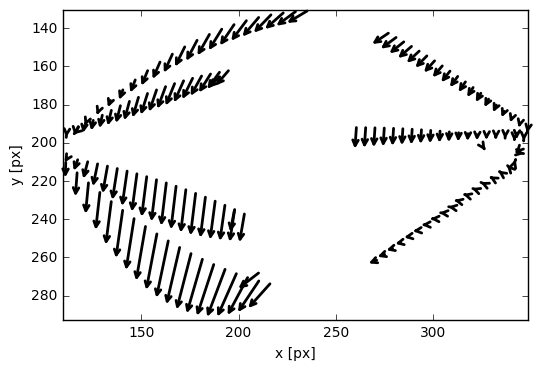

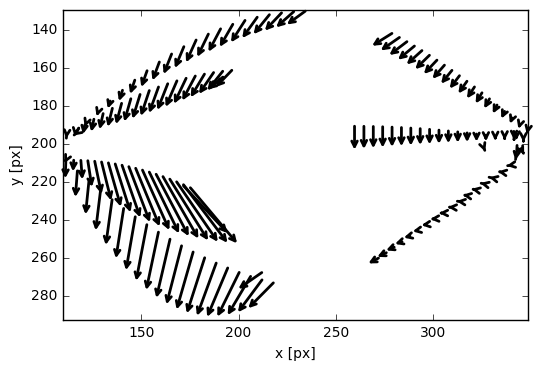

In [112]:
bin_list=[]
def multiples(m, count):
    for i in range(count):
        num=i*m
        bin_list.append(int(num))
        
multiples(10,280) #(binsize,numberofbins)


sorted_df['bin'] = pd.cut(sorted_df['particle'], bin_list)

binned_particles = []
for i in range(0,10):
    for j in range(1,len(bin_list)):
        binned_particles.append(j)
#print binned_particles


df = sorted_df.groupby(['frame', 'bin'], as_index=False)['x', 'y'].mean()
df['particle'] = pd.DataFrame({'particles': binned_particles})

tp.plot_displacements(df, 9,1)
tp.plot_displacements(df, 9,0)